#### AI Usage  
The code is partly generated by GPT-4o with user input, review, and redact.

In [1]:
# Import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#### Primary Dataset Import and Validation

In [2]:
df_carrier = []

files = [
    '2014_T_T100D_SEGMENT_ALL_CARRIER.csv', '2015_T_T100D_SEGMENT_ALL_CARRIER.csv', 
    '2016_T_T100D_SEGMENT_ALL_CARRIER.csv', '2017_T_T100D_SEGMENT_ALL_CARRIER.csv', 
    '2018_T_T100D_SEGMENT_ALL_CARRIER.csv', '2019_T_T100D_SEGMENT_ALL_CARRIER.csv', 
    '2020_T_T100D_SEGMENT_ALL_CARRIER.csv', '2021_T_T100D_SEGMENT_ALL_CARRIER.csv', 
    '2022_T_T100D_SEGMENT_ALL_CARRIER.csv', '2023_T_T100D_SEGMENT_ALL_CARRIER.csv', 
    '2024_T_T100D_SEGMENT_ALL_CARRIER.csv'
]

folder_path = 'DATA'

df_carrier = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in files], ignore_index=True)
# df_carrier.replace(0, np.nan, inplace=True)

df_carrier.head()

,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,RAMP_TO_RAMP,AIR_TIME,...,ORIGIN_STATE_NM,DEST,DEST_STATE_NM,AIRCRAFT_TYPE,AIRCRAFT_CONFIG,YEAR,QUARTER,MONTH,DISTANCE_GROUP,CLASS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Georgia,ATL,Georgia,456,1,2014,1,3,1,F
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Florida,FLL,Florida,456,1,2014,1,3,1,F
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Florida,GNV,Florida,456,1,2014,1,3,1,F
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,Colorado,DEN,Colorado,698,1,2014,2,5,1,F
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,California,SAN,California,698,1,2014,1,1,1,F


In [3]:
# Validation

# Count the number of rows where DEPARTURES_PERFORMED is 0 and AIR_TIME > 0
INVALID_DEPARTURE_PERFORMED = ((df_carrier['DEPARTURES_PERFORMED'] == 0) & (df_carrier['AIR_TIME'] > 0)).sum()
print(f"Number of invalid DEPARTURES_PERFORMED: {INVALID_DEPARTURE_PERFORMED}")

# If DEPARTURES_PERFORMED is 0 and AIR_TIME > 0, set DEPARTURES_PERFORMED to 1
df_carrier.loc[(df_carrier['DEPARTURES_PERFORMED'] == 0) & (df_carrier['AIR_TIME'] > 0), 'DEPARTURES_PERFORMED'] = 1

# Else if DEPARTURES_PERFORMED is 0 then remove the rows as there is no AIR_TIME.
df_carrier = df_carrier[~((df_carrier['DEPARTURES_PERFORMED'] == 0) & (df_carrier['AIR_TIME'] == 0))]

# If DISTANCE > 0 and AIR_TIME = 0 then AIR_TIME is missing
df_carrier.loc[(df_carrier['DISTANCE'] > 0) & (df_carrier['AIR_TIME'] == 0), 'AIR_TIME'] = np.nan

# If DISTANCE > 0 and RAMP_TO_RAMP = 0 then RAMP_TO_RAMP is missing
df_carrier.loc[(df_carrier['DISTANCE'] > 0) & (df_carrier['RAMP_TO_RAMP'] == 0), 'RAMP_TO_RAMP'] = np.nan

# Calculate GROUND_TIME as the difference between RAMP_TO_RAMP and AIR_TIME
df_carrier['GROUND_TIME'] = df_carrier['RAMP_TO_RAMP'] - df_carrier['AIR_TIME']

# Count the number of rows where RAMP_TO_RAMP is less than AIR_TIME
INVALID_AIR_TIME = (df_carrier['RAMP_TO_RAMP'] < df_carrier['AIR_TIME']).sum()
print(f"Number of invalid AIR_TIME: {INVALID_AIR_TIME}")



Number of invalid DEPARTURES_PERFORMED: 648
Number of invalid AIR_TIME: 0


#### Imputation

In [4]:
# Step 1: Split the data into two parts: one with missing AIR_TIME and one without
df_missing_air_time = df_carrier[df_carrier['AIR_TIME'].isnull()]
df_complete = df_carrier[df_carrier['AIR_TIME'].notnull()]

# Step 2: Train a linear regression model using the complete data
X_train = df_complete[['DISTANCE']]  # Predictor: DISTANCE
y_train = df_complete['AIR_TIME']    # Target: AIR_TIME

# Initialize the regression model
reg_model = LinearRegression()

# Train the model
reg_model.fit(X_train, y_train)

# Step 3: Predict the missing AIR_TIME values using the trained model
X_missing = df_missing_air_time[['DISTANCE']]  # Use the DISTANCE values where AIR_TIME is missing
df_missing_air_time.loc[:, 'AIR_TIME'] = reg_model.predict(X_missing)

# Step 4: Impute the missing values in the original DataFrame
df_carrier.loc[df_carrier['AIR_TIME'].isnull(), 'AIR_TIME'] = df_missing_air_time['AIR_TIME']

In [5]:
# Step 1: Split the data into two parts: one with missing RAMP_TO_RAMP and one without
df_missing_ramp = df_carrier[df_carrier['RAMP_TO_RAMP'].isnull()]
df_complete = df_carrier[df_carrier['RAMP_TO_RAMP'].notnull()]

# Step 2: Train a linear regression model using the complete data
X_train = df_complete[['PASSENGERS', 'FREIGHT']]  # Predictors: PASSENGERS and FREIGHT
y_train = df_complete['RAMP_TO_RAMP']             # Target: RAMP_TO_RAMP

# Initialize the regression model
reg_model = LinearRegression()

# Train the model
reg_model.fit(X_train, y_train)

# Step 3: Predict the missing RAMP_TO_RAMP values using the trained model
X_missing = df_missing_ramp[['PASSENGERS', 'FREIGHT']]  # Use PASSENGERS and FREIGHT for missing RAMP_TO_RAMP
df_missing_ramp.loc[:, 'RAMP_TO_RAMP'] = reg_model.predict(X_missing)

# Step 4: Impute the missing values in the original DataFrame
df_carrier.loc[df_carrier['RAMP_TO_RAMP'].isnull(), 'RAMP_TO_RAMP'] = df_missing_ramp['RAMP_TO_RAMP']

In [6]:
# # Check if GROUND_TIME has missing values (NaN)
# missing_data = df_carrier['GROUND_TIME'].isnull()

# # Display rows where GROUND_TIME is missing
# df_missing_ground_time = df_carrier[missing_data]

# # Show the missing data
# df_missing_ground_time.head()

df_carrier['GROUND_TIME'] = df_carrier['RAMP_TO_RAMP'] - df_carrier['AIR_TIME']

#### Import Supporting Files and Tables

In [7]:
# Import lookup tables
folder_path = 'TABLES'
tab_aircraft_config = pd.read_csv(os.path.join(folder_path, 'L_AIRCRAFT_CONFIG.csv'))
tab_aircraft_type = pd.read_csv(os.path.join(folder_path, 'L_AIRCRAFT_TYPE.csv'))
tab_airport_id = pd.read_csv(os.path.join(folder_path, 'L_AIRPORT_ID.csv'))
tab_airport = pd.read_csv(os.path.join(folder_path, 'L_AIRPORT.csv'))
tab_distance_group = pd.read_csv(os.path.join(folder_path, 'L_DISTANCE_GROUP_500.csv'))
tab_service_class = pd.read_csv(os.path.join(folder_path, 'L_SERVICE_CLASS.csv'))
tab_unique_carriers = pd.read_csv(os.path.join(folder_path, 'L_UNIQUE_CARRIERS.csv'))


In [8]:
# Import df_aiport (predictor dataset)

df_airport = []
folder_path = 'DATA'
df_airport = pd.read_csv(os.path.join(folder_path, 'airports.csv'))

df_airport.head()


,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,K00A,NaN,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,00AN,NaN,00AN,NaN,NaN,NaN


In [9]:
# Filter data with IATA only and US only
df_filtered = df_airport[(df_airport['iata_code'].notna()) & (df_airport['iso_country'] == 'US')]

# Create a lookup table for predictor
airport_tab_fac = df_filtered[['iata_code', 'latitude_deg', 'longitude_deg', 'elevation_ft', 'type']]

In [10]:
# Merge df_carrier with all columns from airport_tab_fac
df_carrier = df_carrier.merge(airport_tab_fac, 
                              left_on='ORIGIN', 
                              right_on='iata_code', 
                              how='left')

# Drop the 'iata_code' column
df_carrier.drop(columns=['iata_code'], inplace=True)

#### Analysis

In [11]:
# Filter Michigan only
df_michigan = df_carrier[df_carrier['ORIGIN_STATE_NM'] == 'Michigan']

# Create a pivot table for Michigan
pivot_table_michigan = pd.pivot_table(df_michigan, 
                                      values='DEPARTURES_PERFORMED', 
                                      index='YEAR', 
                                      columns='MONTH', 
                                      aggfunc='sum')

# Display the pivot table
pivot_table_michigan = pivot_table_michigan / 1000

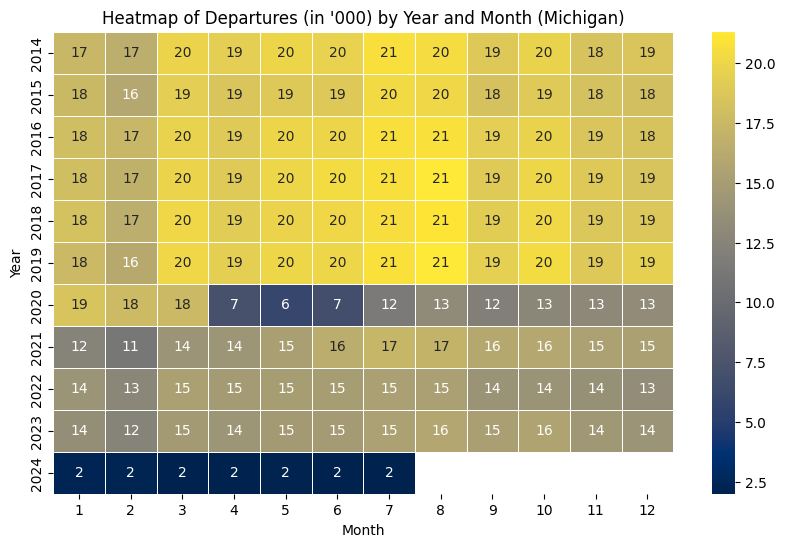

In [12]:
# Create the heatmap
plt.figure(figsize=(10, 6))  # Set the figure size
sns.heatmap(pivot_table_michigan, annot=True, fmt=".0f", cmap='cividis', linewidths=.5)

# Add titles and labels
plt.title('Heatmap of Departures (in \'000) by Year and Month (Michigan)')
plt.xlabel('Month')
plt.ylabel('Year')

# Show the heatmap
plt.show()

Summary Statistics for GROUND_TIME:
count    3.924284e+06
mean     4.722786e+02
std      1.035546e+03
min     -1.409036e+04
25%      2.500000e+01
50%      1.300000e+02
75%      6.200000e+02
max      8.948300e+05
Name: GROUND_TIME, dtype: float64

Missing values in GROUND_TIME: 0


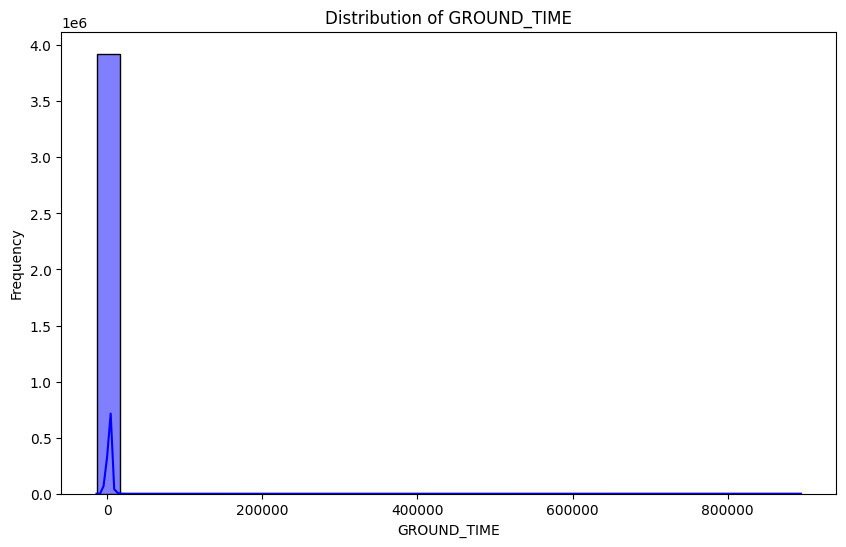

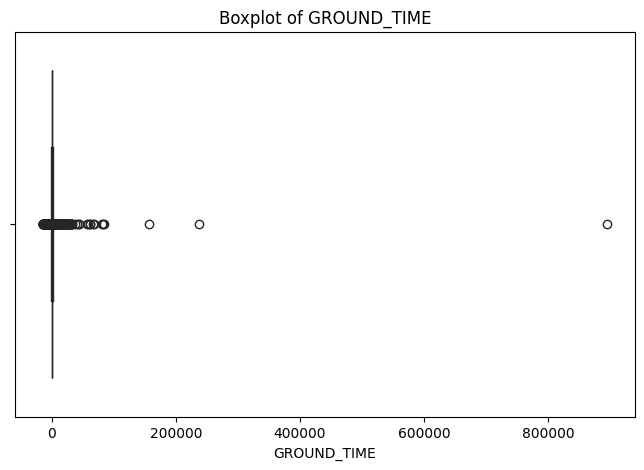

In [13]:
# Step 1: Summary statistics for GROUND_TIME
ground_time_summary = df_carrier['GROUND_TIME'].describe()
print("Summary Statistics for GROUND_TIME:")
print(ground_time_summary)

# Step 2: Check for missing values
missing_ground_time = df_carrier['GROUND_TIME'].isnull().sum()
print(f"\nMissing values in GROUND_TIME: {missing_ground_time}")

# Step 3: Plotting the distribution of GROUND_TIME
plt.figure(figsize=(10, 6))

# Histogram and KDE plot for GROUND_TIME
sns.histplot(df_carrier['GROUND_TIME'], kde=True, bins=30, color='blue')
plt.title('Distribution of GROUND_TIME')
plt.xlabel('GROUND_TIME')
plt.ylabel('Frequency')

plt.show()

# Step 4: Boxplot to detect outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_carrier['GROUND_TIME'], color='green')
plt.title('Boxplot of GROUND_TIME')
plt.xlabel('GROUND_TIME')

plt.show()

In [14]:
# Log transform the GROUND_TIME to reduce skewness
df_carrier['LOG_GROUND_TIME'] = np.log1p(df_carrier['GROUND_TIME'])  # log1p to handle 0 values



c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


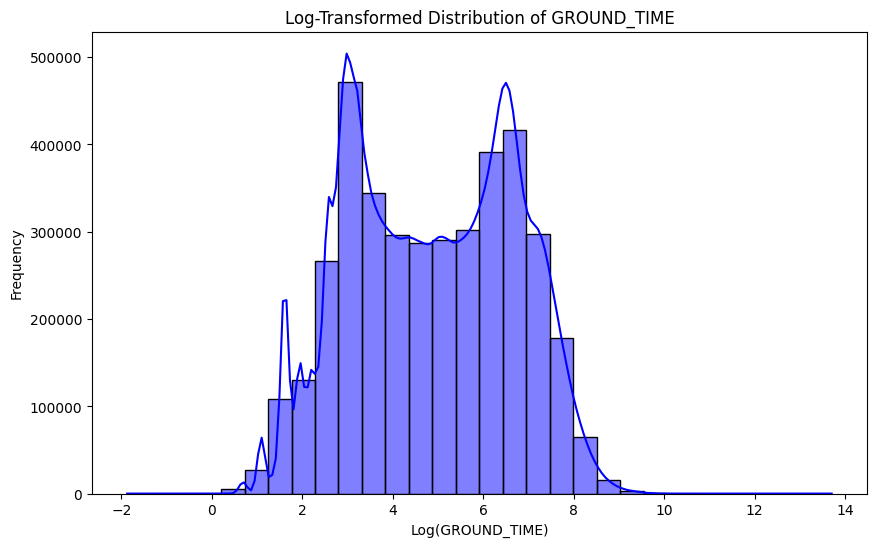

In [15]:
# Plot the log-transformed GROUND_TIME distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_carrier['LOG_GROUND_TIME'], kde=True, bins=30, color='blue')
plt.title('Log-Transformed Distribution of GROUND_TIME')
plt.xlabel('Log(GROUND_TIME)')
plt.ylabel('Frequency')

plt.show()

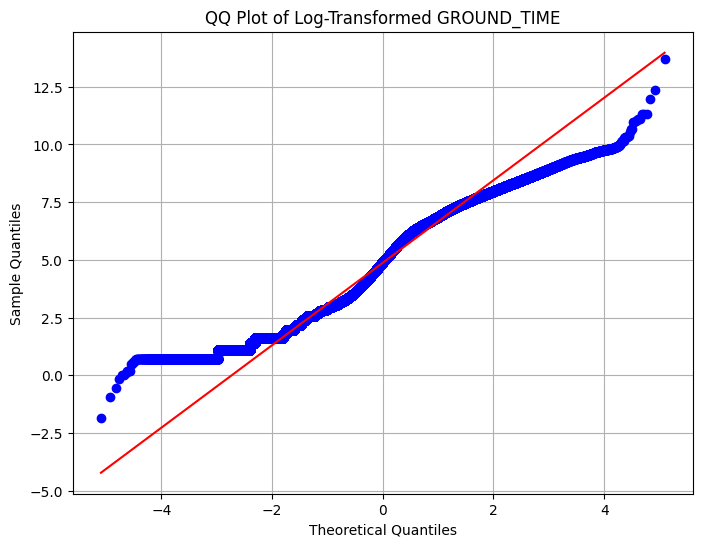

In [16]:
# Ensure there are no NaN values in data
log_ground_time_data = df_carrier['LOG_GROUND_TIME'].dropna()

# Generate the QQ plot with the reference line
plt.figure(figsize=(8, 6))
stats.probplot(log_ground_time_data, dist="norm", plot=plt)
plt.title('QQ Plot of Log-Transformed GROUND_TIME')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)  # Add grid for better readability
plt.show()

In [17]:
# Translate aircraft_config using tab_aircraft_config
tab_aircraft_config.rename(columns={'Description': 'AIRCRAFT_CONFIG_DESC'}, inplace=True)

df_carrier = df_carrier.merge(tab_aircraft_config, 
                              left_on='AIRCRAFT_CONFIG', 
                              right_on='Code', 
                              how='left')

df_carrier.drop(columns=['Code'], inplace=True)

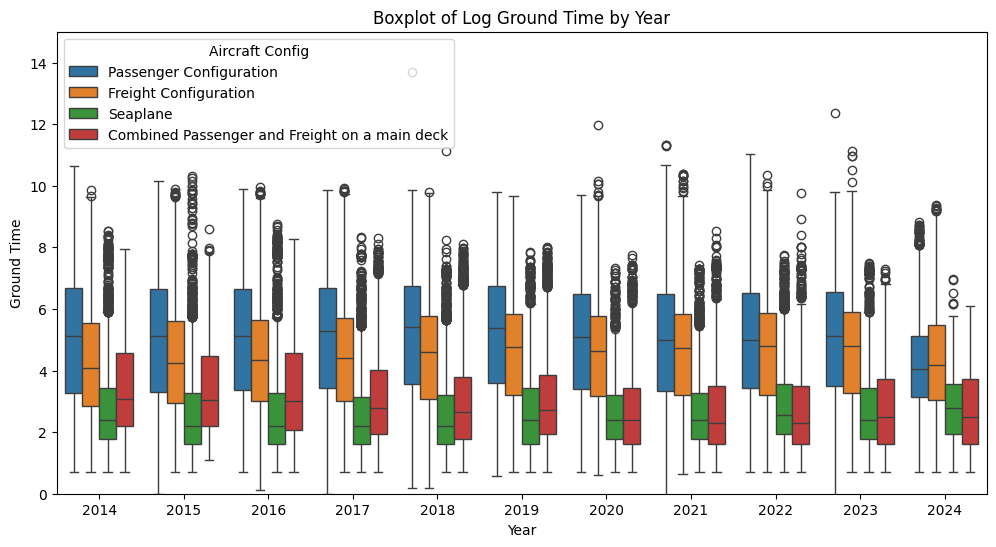

In [18]:
# Create the boxplot for LOG_GROUND_TIME by YEAR, divided by AIRCRAFT_CONFIG
plt.figure(figsize=(12, 6))

sns.boxplot(data=df_carrier, x='YEAR', y='LOG_GROUND_TIME', hue='AIRCRAFT_CONFIG_DESC')
plt.ylim(0, 15)
plt.title('Boxplot of Log Ground Time by Year')
plt.legend(loc='upper left', title='Aircraft Config')
plt.xlabel('Year')
plt.ylabel('Ground Time')
plt.show()

Correlation Matrix:
                      DEPARTURES_SCHEDULED  DEPARTURES_PERFORMED   PAYLOAD  \
DEPARTURES_SCHEDULED              1.000000              0.951546  0.688506   
DEPARTURES_PERFORMED              0.951546              1.000000  0.729972   
PAYLOAD                           0.688506              0.729972  1.000000   
SEATS                             0.814800              0.839631  0.796214   
PASSENGERS                        0.791503              0.817077  0.788106   
FREIGHT                           0.016048              0.044642  0.498023   
MAIL                              0.067852              0.084518  0.194393   
DISTANCE                          0.005562             -0.003443  0.210563   
RAMP_TO_RAMP                      0.749750              0.780383  0.771885   
AIR_TIME                          0.696771              0.725879  0.749008   
AIRCRAFT_TYPE                     0.096288              0.074677  0.202554   
AIRCRAFT_CONFIG                  -0.145819  

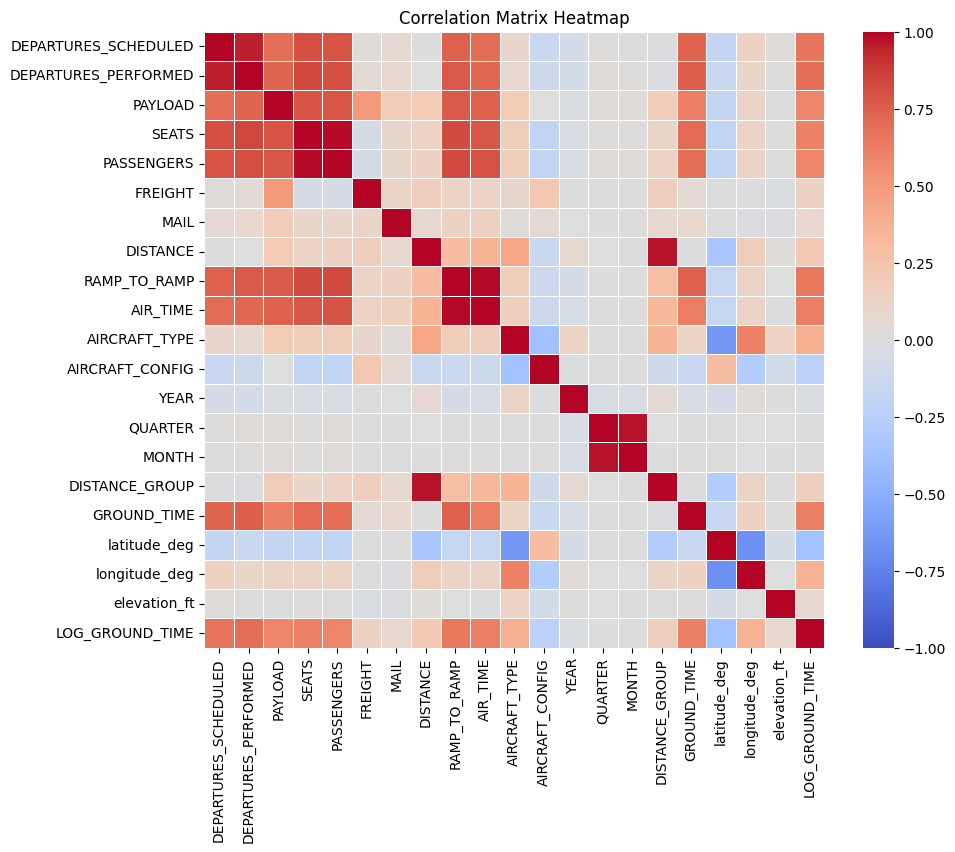

In [19]:
# Select only numerical columns from the DataFrame
df_numerical = df_carrier.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for the numerical columns
correlation_matrix = df_numerical.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()


#### Encoding
Encoding is not necessary for the key variables. Below is a rule-based encoding applied on heatmap to improve clarity.

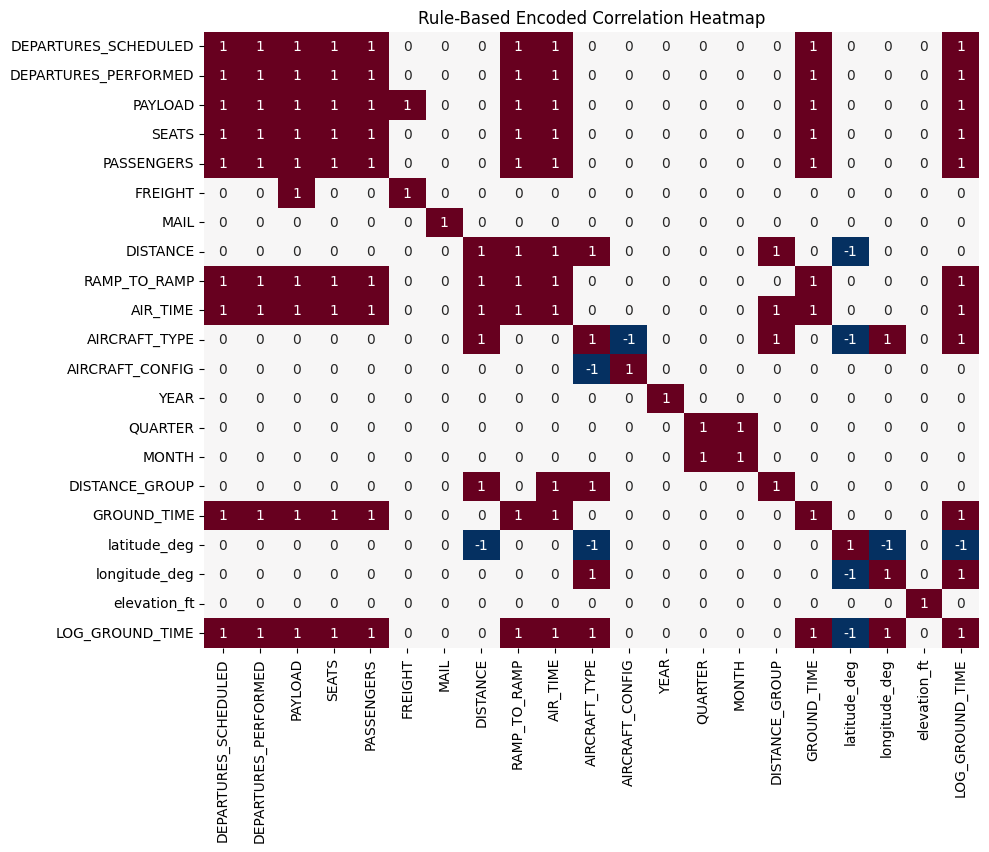

In [20]:
# Define a rule-based encoding for strong and weak correlations
def encode_correlation(corr_matrix, low_threshold=0.3):
    # Apply the encoding based on the rule (0.3 threshold for weak vs. strong)
    encoded_corr = corr_matrix.apply(lambda x: np.where(x <= -low_threshold, -1, np.where(x >= low_threshold, 1, 0)))
    return encoded_corr

# Apply the encoding to the correlation matrix
encoded_corr = encode_correlation(correlation_matrix, low_threshold=0.3)

# Plot the heatmap using a diverging colormap
plt.figure(figsize=(10, 8))
sns.heatmap(encoded_corr, cmap="RdBu_r", center=0, annot=True, cbar=False)
plt.title('Rule-Based Encoded Correlation Heatmap')
plt.show()

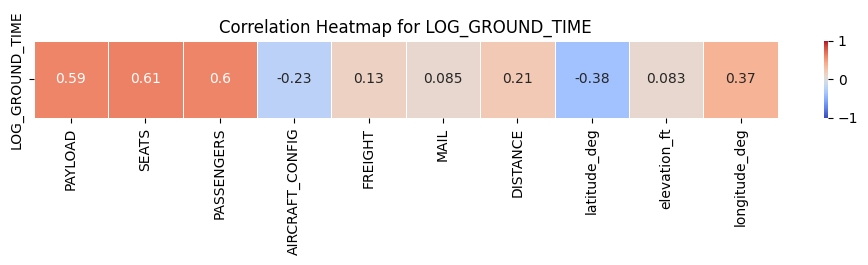

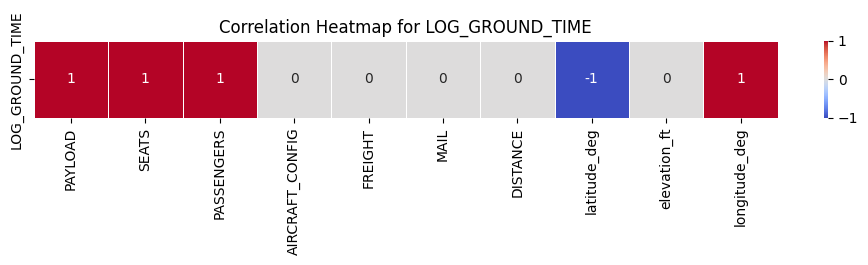

In [21]:
# Filter the correlation matrix to only include the 'LOG_GROUND_TIME' row
predictor_candidate = ['PAYLOAD', 'SEATS', 'PASSENGERS', 'AIRCRAFT_CONFIG', 'FREIGHT', 'MAIL', 'DISTANCE', 'latitude_deg', 'elevation_ft', 'longitude_deg']
log_ground_time_corr = correlation_matrix.loc[['LOG_GROUND_TIME'], predictor_candidate]
log_ground_time_corr_encoded = encoded_corr.loc[['LOG_GROUND_TIME'], predictor_candidate]

# Create a heatmap for the filtered data
plt.figure(figsize=(12, 1)) 
#sns.heatmap(log_ground_time_corr.T, annot=False, cmap='cividis', linewidths=0.5, cbar=True)
sns.heatmap(log_ground_time_corr, annot=True, cmap='coolwarm', linewidths=0.5, cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Heatmap for LOG_GROUND_TIME')
plt.show()




# Create a heatmap for the filtered data
plt.figure(figsize=(12, 1)) 
#sns.heatmap(log_ground_time_corr.T, annot=False, cmap='cividis', linewidths=0.5, cbar=True)
sns.heatmap(log_ground_time_corr_encoded, annot=True, cmap='coolwarm', linewidths=0.5, cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Heatmap for LOG_GROUND_TIME')
plt.show()

# Streamlit starts here

#### Create summary output for streamlit

In [22]:
# Replace 0 with NaN
df_carrier.replace(0, np.nan, inplace=True)

# Group by carrier and year, and calculate total flights and average delay
df_summary = df_carrier.groupby(['AIRCRAFT_CONFIG_DESC', 'YEAR']).agg(
    total_flights=('DEPARTURES_PERFORMED', 'sum'),
    average_ground_time=('GROUND_TIME', 'mean')
).reset_index()

# Display the summary DataFrame
df_summary.head()

# Define the output folder
output_folder = 'OUTPUT'

# Export the summary DataFrame as a CSV
output_file_path = os.path.join(output_folder, 'summarized_flight_data.csv')
df_summary.to_csv(output_file_path, index=False)
print(f"Summary CSV exported successfully to {output_file_path}!")

# Also export the heatmap as CSV
output_file_path = os.path.join(output_folder, 'correlation_matrix.csv')
correlation_matrix.to_csv(output_file_path, index=False)
print(f"Correlation Matrix CSV exported successfully to {output_file_path}!")



Summary CSV exported successfully to OUTPUT\summarized_flight_data.csv!
Correlation Matrix CSV exported successfully to OUTPUT\correlation_matrix.csv!


#### Histogram Summary

In [23]:
# Histogram
def create_histogram_summary(df, column, bins=300):
    df = df[df[column] > 0]

    hist, bin_edges = np.histogram(df[f'{column}'], bins=bins)

    histogram_summary = pd.DataFrame({
        'bin_edges': bin_edges[:-1],
        'frequency': hist
    })

    return histogram_summary


histogram_summary = create_histogram_summary(df_carrier, 'LOG_GROUND_TIME')
output_file_path = os.path.join(output_folder, 'histogram_summary_ground_time.csv')
histogram_summary.to_csv(output_file_path, index=False)
print(f"Historam Summary CSV exported successfully to {output_file_path}!")

Historam Summary CSV exported successfully to OUTPUT\histogram_summary_ground_time.csv!


#### Boxplot

Boxplot Summary CSV exported successfully to OUTPUT\boxplot_summary.csv!


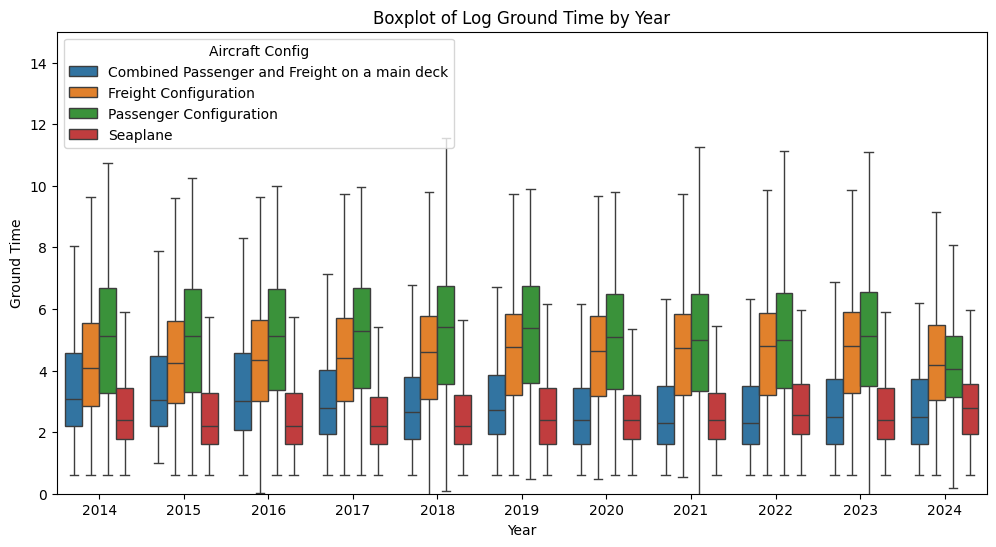

In [24]:
# Create a function to generate weighted grouped data from summary statistics
epsilon = 0.1  # A very small value to adjust min/max

def create_grouped_data_from_summary(df_summary):
    grouped_data = []
    for i, row in df_summary.iterrows():
        year = row.name[0]
        config = row.name[1]

        # Calculate the IQR (Interquartile Range)
        IQR = row['75%'] - row['25%']

        # Adjust the lower and upper whiskers with a small epsilon
        lower_bound = max(row['min'] - epsilon, row['25%'] - 1.5 * IQR)  # Lower whisker
        upper_bound = min(row['max'] + epsilon, row['75%'] + 1.5 * IQR)  # Upper whisker

        # Create weighted data for each summary statistic
        grouped_data.append([year, config, lower_bound, 'lower_bound'])  # Lower whisker
        grouped_data.append([year, config, row['25%'], 'Q1'])            # Q1 (25th percentile)
        grouped_data.append([year, config, row['50%'], 'median'])        # Median (50th percentile)
        grouped_data.append([year, config, row['75%'], 'Q3'])            # Q3 (75th percentile)
        grouped_data.append([year, config, upper_bound, 'upper_bound'])  # Upper whisker

    # Create a DataFrame for the grouped data
    return pd.DataFrame(grouped_data, columns=['YEAR', 'AIRCRAFT_CONFIG_DESC', 'LOG_GROUND_TIME', 'Statistic'])



# Generate the grouped data from the summary statistics
df_boxplot_summary = df_carrier.groupby(['YEAR', 'AIRCRAFT_CONFIG_DESC']).LOG_GROUND_TIME.describe(percentiles=[0.25, 0.5, 0.75])
df_boxplot = create_grouped_data_from_summary(df_boxplot_summary)

# Plot the boxplot using this grouped data
plt.figure(figsize=(12, 6))

# Since we have grouped data, we can use stripplot to simulate a boxplot-like structure
sns.boxplot(x='YEAR', y='LOG_GROUND_TIME', hue='AIRCRAFT_CONFIG_DESC', data=df_boxplot)

# Output to csv file for Streamlit
output_file_path = os.path.join(output_folder, 'boxplot_summary.csv')
df_boxplot.to_csv(output_file_path, index=False)
print(f"Boxplot Summary CSV exported successfully to {output_file_path}!")

# Customize the plot
plt.ylim(0, 15)
plt.title('Boxplot of Log Ground Time by Year')
plt.legend(loc='upper left', title='Aircraft Config')
plt.xlabel('Year')
plt.ylabel('Ground Time')

plt.show()

#### QQ Plot

$n = \frac{Z^2 \cdot p \cdot (1 - p)}{E^2}$

QQ Sample CSV exported successfully to OUTPUT\qq_sample.csv!


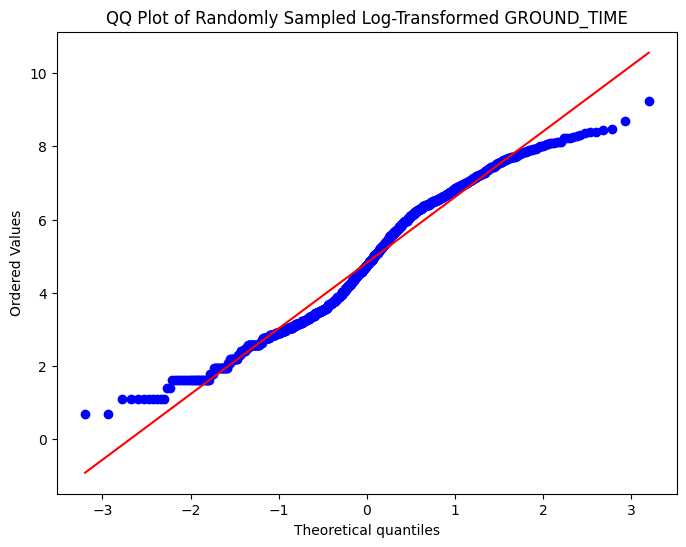

In [41]:
# Random sampling from the original dataset
sample_size = 1000  # Define your sample size
df_sampled = df_carrier.sample(n=sample_size, random_state=0)  # Set a seed for reproducibility

# Ensure that the LOG_GROUND_TIME column exists and has no missing values
log_ground_time_sampled = df_sampled['LOG_GROUND_TIME'].dropna()

# Output to csv file for Streamlit
output_file_path = os.path.join(output_folder, 'qq_sample.csv')
log_ground_time_sampled.to_csv(output_file_path, index=False)
print(f"QQ Sample CSV exported successfully to {output_file_path}!")

# Create a QQ plot using the sampled data
plt.figure(figsize=(8, 6))
stats.probplot(log_ground_time_sampled, dist="norm", plot=plt)
plt.title("QQ Plot of Randomly Sampled Log-Transformed GROUND_TIME")
plt.show()